In [7]:
!pip install lda
!pip install gensim
!pip install konlpy
!pip install pyLDAvis
!pip install pyLDAvis.gensim
!pip install pymysql # mysql database connection library
!jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

import lda
import gensim
import pyLDAvis
import pyLDAvis.gensim_models                # import pyLDAvis.gensim 현재는 모듈명이 변경
from konlpy.tag import Kkma
from gensim import corpora, models
from gensim.models import CoherenceModel

import re
import time
import datetime
import numpy as np
import pandas as pd                          # Querying results to make dataframe(to divide datas)
import pymysql.cursors                       # For Request Query String
import matplotlib.pyplot as plt
from google.colab import drive
from string import punctuation

drive.mount('/content/drive', force_remount=True)

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-notebook", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/jupyter_core/application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 845, in launch_instance
    app.initialize(argv)
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 88, in inner
    return method(app, *args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/notebook/notebookapp.py", line 1507, in initialize
    self.init_webapp()
  File "/usr/local/lib/python3.7/dist-packages/notebook/notebookapp.py", line 1297, in init_webapp
    self.http_server.listen(port, self.ip)
  File "/

In [8]:
conn = pymysql.connect(host='csrd.cksngv0eixsu.ap-northeast-2.rds.amazonaws.com', port=3306, user='admin', password='qwerty1!', \
db='before-pp', charset='utf8', autocommit=True, cursorclass=pymysql.cursors.DictCursor)        # mysql connect inform
sql = "SELECT * FROM `before-pp`.bf_pl order by pl_id desc;"                                    # assign query
cur = conn.cursor()                                                                             # open to query
cur.execute(sql)                                                                                # excute query
result = cur.fetchall()                                                                         # merging result
conn.close()                                                                                    # DB disconnect
df = pd.DataFrame(result)                                                                       # 전체 음악리스트 확인(playlist_id 기준이기 때문에 중복값 들어있음)
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)                  # 중복 처리

In [9]:
df['result'] = df['pl_name'] + " " + df['pl_intro']
df['result']

0       듣는순간 흥폭발 신나고 중독성 있는 K-POP 케이팝이 끌리는날! 100곡의 신나고...
1       임창정이 추천하는 시대와 장르를 초월하는 음악 저는 시대와 장르를 초월하는 다양한 ...
2       [일상의 BGM] 감각적인 비트와 멜로디  2019.11.2비트감 있고 세련된 멜로...
3       크리에이티브 영감을 자극하는 선율의 연주곡 집중이 필요할 때, 창의적인 작업 중일 ...
4                      작업할 때 듣기 좋은 잔잔한 POP 당신의 작업을 응원합니다.
                              ...                        
5510                           주말의 여유를 느끼고 싶을때 들으면 좋은 곡들 
5511          늦은 밤에 혼자 듣기 좋은 발라드 노래 늦은 밤 혼자 듣기 좋은 발라드 노래 
5512                        싸이월드 bgm 인기곡차트를 휩쓴 추억의 노래들 ( 
5513                     펑펑 울고 싶은 날 들어요. 이별을 노래한 잔잔한 발라드 
5514    세월이 흘러도 영원할 명곡, LP판 감성의 올드팝 세월이 흘러도 영원할 명곡,심금을...
Name: result, Length: 5515, dtype: object

In [10]:
df_test = list(df.result.astype("str"))     # 텍스트 부분을 리스트로 만든 후 저장, 리스트에 저장 하기 전 가끔씩 문자열로 인식 하지 않는 오류가 있음
                                            # 추후에 게시글 단위로 문서를 나누고 해당 문서의 의미를 찾아내기 위해 리스트로 분리해서 나눠줘야 하기 때문
df_test

['듣는순간 흥폭발 신나고 중독성 있는 K-POP 케이팝이 끌리는날! 100곡의 신나고 중독성있는 케이팝 들어봐요',
 '임창정이 추천하는 시대와 장르를 초월하는 음악 저는 시대와 장르를 초월하는 다양한 종류의 음악을 좋아합니다.저에게 음악적으로 영향을 준 좋아하는 멜로디 라인들의 곡을 공유하고 싶어요.제가 따라하고 싶은 음악들을 함께 감상해주세요.',
 '[일상의 BGM] 감각적인 비트와 멜로디  2019.11.2비트감 있고 세련된 멜로디의 재즈힙합 곡 위주로 모아봤어요.루즈하지않고 들으면 들을수록 묘하게 끌리는 멜로디입니다 :)일상을 소중하고 특별하게 !음악 듣고 행복한 하루가 되셨음 해요 :)',
 '크리에이티브 영감을 자극하는 선율의 연주곡 집중이 필요할 때, 창의적인 작업 중일 때, 업무 효율을 늘리고 싶을 때 들어보세요. 집중력을 높여줘서 작업도 업무도 빨리 마무리하실 수 있을 거예요. 공부할 때, 휴식이 필요할 때도 좋아요. 적게 일하고 많이 버세요.',
 '작업할 때 듣기 좋은 잔잔한 POP 당신의 작업을 응원합니다.',
 '나얼&에코브릿지의 추천 플리! [Sympathy(공감)] 나얼&에코브릿지의 Diggin On Air 4화 [Sympathy(공감)]나얼이 생각하는 퀸시존스의 8090 명반과 에코브릿지가 추천해주는 연주자 입장에서 영감을 받은 곡들까지! 매주 토요일 오후 7시! 음잘알이 추천해주는 플레이리스트를 멜론 스테이션에서 만나보세요. ',
 "빌리 아일리시가 한국 팬들과 함께 듣고 싶은 요즘 최애곡 빌리 아일리시가 두 번째 정규 앨범 'Happier Than Ever'의 '발매를 기념하기 위해 한국 팬들과 함께 공유하고 싶은 플레이리스트를 보내왔습니다 :) 빌리 아일리시가 요즘 듣는 최애곡이라고 하는 만큼, 이번 앨범의 이미지와 사운드에 영향을 준 듯한 노래들도 보이네요.때로는 차분한 칠링 감성, 때로는 강렬하고 독특한 사운드로 영감을 자극하는 빌리 아일리시의 요즘 최애곡 플레이리스트 꼭 한 번 들어보세요.",
 '우리에게 영감을 주는

In [11]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

clean_title = []
for sent in df_test:
    clean = strip_punctuation(sent)
    clean_title.append(clean)

In [12]:
len(clean_title), clean_title

(5515,
 ['듣는순간 흥폭발 신나고 중독성 있는 KPOP 케이팝이 끌리는날 100곡의 신나고 중독성있는 케이팝 들어봐요',
  '임창정이 추천하는 시대와 장르를 초월하는 음악 저는 시대와 장르를 초월하는 다양한 종류의 음악을 좋아합니다저에게 음악적으로 영향을 준 좋아하는 멜로디 라인들의 곡을 공유하고 싶어요제가 따라하고 싶은 음악들을 함께 감상해주세요',
  '일상의 BGM 감각적인 비트와 멜로디  2019112비트감 있고 세련된 멜로디의 재즈힙합 곡 위주로 모아봤어요루즈하지않고 들으면 들을수록 묘하게 끌리는 멜로디입니다 일상을 소중하고 특별하게 음악 듣고 행복한 하루가 되셨음 해요 ',
  '크리에이티브 영감을 자극하는 선율의 연주곡 집중이 필요할 때 창의적인 작업 중일 때 업무 효율을 늘리고 싶을 때 들어보세요 집중력을 높여줘서 작업도 업무도 빨리 마무리하실 수 있을 거예요 공부할 때 휴식이 필요할 때도 좋아요 적게 일하고 많이 버세요',
  '작업할 때 듣기 좋은 잔잔한 POP 당신의 작업을 응원합니다',
  '나얼에코브릿지의 추천 플리 Sympathy공감 나얼에코브릿지의 Diggin On Air 4화 Sympathy공감나얼이 생각하는 퀸시존스의 8090 명반과 에코브릿지가 추천해주는 연주자 입장에서 영감을 받은 곡들까지 매주 토요일 오후 7시 음잘알이 추천해주는 플레이리스트를 멜론 스테이션에서 만나보세요 ',
  '빌리 아일리시가 한국 팬들과 함께 듣고 싶은 요즘 최애곡 빌리 아일리시가 두 번째 정규 앨범 Happier Than Ever의 발매를 기념하기 위해 한국 팬들과 함께 공유하고 싶은 플레이리스트를 보내왔습니다  빌리 아일리시가 요즘 듣는 최애곡이라고 하는 만큼 이번 앨범의 이미지와 사운드에 영향을 준 듯한 노래들도 보이네요때로는 차분한 칠링 감성 때로는 강렬하고 독특한 사운드로 영감을 자극하는 빌리 아일리시의 요즘 최애곡 플레이리스트 꼭 한 번 들어보세요',
  '우리에게 영감을 주는 신선한 ',
  '작업하면서 틀어놓기 좋은 BGM  취

In [13]:
kkma = Kkma()               # 꼬꼬마 라이브러리 메소드 정의
start = time.time()         # 수행 시간 알기 위한 time 사용

def cleanText(readData):    #텍스트에 포함되어 있는 특수 문자 제거 
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', readData) 
    return text

cleantext = list()

for i in clean_title:   
    ret = re.sub(r"[^가-힣a-zA-Z0-9]"," ",i).lstrip().rstrip()
    cleantext.append(ret)

cleantext

<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<input>:5: DeprecationWarning: invalid escape sequence \?
<ipython-input-13-b56fd46cfd36>:5: DeprecationWarning: invalid escape sequence \?
  text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', readData)


['듣는순간 흥폭발 신나고 중독성 있는 KPOP 케이팝이 끌리는날 100곡의 신나고 중독성있는 케이팝 들어봐요',
 '임창정이 추천하는 시대와 장르를 초월하는 음악 저는 시대와 장르를 초월하는 다양한 종류의 음악을 좋아합니다저에게 음악적으로 영향을 준 좋아하는 멜로디 라인들의 곡을 공유하고 싶어요제가 따라하고 싶은 음악들을 함께 감상해주세요',
 '일상의 BGM 감각적인 비트와 멜로디  2019112비트감 있고 세련된 멜로디의 재즈힙합 곡 위주로 모아봤어요루즈하지않고 들으면 들을수록 묘하게 끌리는 멜로디입니다 일상을 소중하고 특별하게 음악 듣고 행복한 하루가 되셨음 해요',
 '크리에이티브 영감을 자극하는 선율의 연주곡 집중이 필요할 때 창의적인 작업 중일 때 업무 효율을 늘리고 싶을 때 들어보세요 집중력을 높여줘서 작업도 업무도 빨리 마무리하실 수 있을 거예요 공부할 때 휴식이 필요할 때도 좋아요 적게 일하고 많이 버세요',
 '작업할 때 듣기 좋은 잔잔한 POP 당신의 작업을 응원합니다',
 '나얼에코브릿지의 추천 플리 Sympathy공감 나얼에코브릿지의 Diggin On Air 4화 Sympathy공감나얼이 생각하는 퀸시존스의 8090 명반과 에코브릿지가 추천해주는 연주자 입장에서 영감을 받은 곡들까지 매주 토요일 오후 7시 음잘알이 추천해주는 플레이리스트를 멜론 스테이션에서 만나보세요',
 '빌리 아일리시가 한국 팬들과 함께 듣고 싶은 요즘 최애곡 빌리 아일리시가 두 번째 정규 앨범 Happier Than Ever의 발매를 기념하기 위해 한국 팬들과 함께 공유하고 싶은 플레이리스트를 보내왔습니다  빌리 아일리시가 요즘 듣는 최애곡이라고 하는 만큼 이번 앨범의 이미지와 사운드에 영향을 준 듯한 노래들도 보이네요때로는 차분한 칠링 감성 때로는 강렬하고 독특한 사운드로 영감을 자극하는 빌리 아일리시의 요즘 최애곡 플레이리스트 꼭 한 번 들어보세요',
 '우리에게 영감을 주는 신선한',
 '작업하면서 틀어놓기 좋은 BGM  취미활동작업할때 BGM으로 틀어놓기 

In [14]:
clean_title2 = []
clean_title3 = []
clean_title4 = []
clean_title5 = []
clean_title6 = []
clean_title7 = []
clean_title8 = []
clean_title9 = []
clean_title10 = []

for i in range(len(cleantext)):
    clean_title2.append(re.sub('음악', ' ', cleantext[i]))
    
for i in range(len(clean_title2)):
    clean_title3.append(re.sub('리스트', ' ', clean_title2[i]))

for i in range(len(clean_title3)):
    clean_title4.append(re.sub('플레이리스트', ' ', clean_title3[i]))

for i in range(len(clean_title4)):
    clean_title5.append(re.sub('플레이', ' ', clean_title4[i]))

for i in range(len(clean_title5)):
    clean_title6.append(re.sub('모음', ' ', clean_title5[i]))

for i in range(len(clean_title6)):
    clean_title7.append(re.sub('노래', ' ', clean_title6[i]))

for i in range(len(clean_title7)):
    clean_title8.append(re.sub('오늘', ' ', clean_title7[i]))

for i in range(len(clean_title8)):
    clean_title9.append(re.sub('우리', ' ', clean_title8[i]))

# for i in range(len(clean_title9)):
#     clean_title10.append(re.sub('우리', ' ', clean_title9[i]))

In [19]:
## 한글 알파벳 외에 공백
mkdatasets = clean_title9
dataset = []
for i in range(len(mkdatasets)):
    dataset.append(kkma.nouns(mkdatasets[i]))

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(times)

0:09:37


In [20]:
dataset

[['순간', '흥', '흥폭발', '폭발', '중독성', '케이', '케이팝', '팝', '날', '100', '100곡', '곡'],
 ['임',
  '임창정',
  '창정',
  '추천',
  '시대',
  '장르',
  '초월',
  '저',
  '다양',
  '종류',
  '종류의',
  '의',
  '을',
  '적',
  '영향',
  '멜로디',
  '라인',
  '곡',
  '공유',
  '들',
  '감상'],
 ['일상',
  '감각적',
  '비트',
  '멜로디',
  '2019112',
  '2019112비트감',
  '감',
  '세련',
  '재즈',
  '재즈힙합',
  '힙합',
  '곡',
  '위주',
  '루즈',
  '특별',
  '행복',
  '하루'],
 ['크리',
  '티브',
  '영감',
  '자극',
  '선율',
  '연주곡',
  '집중',
  '필요',
  '때',
  '창',
  '적인',
  '작업',
  '중',
  '업무',
  '효율',
  '보세',
  '집중력',
  '마무리',
  '수',
  '거',
  '공부',
  '휴식',
  '버세'],
 ['작업', '때', '당신', '응원'],
 ['나',
  '얼',
  '코',
  '코브릿지의',
  '브릿',
  '지의',
  '추천',
  '플',
  '플리',
  '리',
  '공감',
  '나얼에코브릿지',
  '4',
  '생각',
  '퀸',
  '퀸시존스',
  '시',
  '존스',
  '8090',
  '명',
  '명반',
  '반',
  '에코',
  '에코브릿지가',
  '지가',
  '연주자',
  '입장',
  '영감',
  '곡',
  '토요일',
  '오후',
  '7',
  '7시',
  '시',
  '음',
  '알',
  '를',
  '멜론',
  '스테이션'],
 ['리',
  '일리',
  '일리시가',
  '시가',
  '한국',
  '팬',
  '요즘',
  '최',
  '최애곡',
  '애곡',


In [21]:
high_score_reviews = dataset
high_score_reviews = [[y for y in x if not len(y) == 1]
                      for x in high_score_reviews]

dictionary = corpora.Dictionary(high_score_reviews)
corpus = [dictionary.doc2bow(text) for text in high_score_reviews]

#### CoherenceModel 을 통한 토픽 최적화

* 의미 : 토픽이 얼마나 의미론적으로 일관성 있는지 판단. 높을수록 의미론적 일관성 높음
<p>

<p>
 
<p>

<p>

* 주 용도 : 해당 모델이 얼마나 실제로 의미 있는 결과를 내는지 확인
<p>
<p>
    기존에 언어모델 평가로 CoherenceModel만을 사용 후
<p>
<p>
    원하는 토픽 개수의 Coherence 모델을 지속 학습 시켜 토픽을 할당 했으나

In [22]:
coherence_values = []
for i in range(2, 50):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary, topn=10)
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

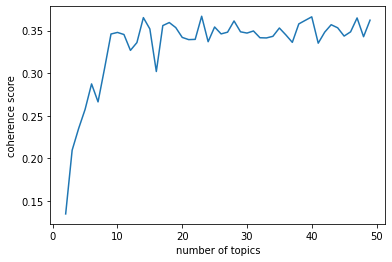

In [23]:
x = range(2, 50)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

#### 언어 모델 평가 방법

* 퍼플렉서티(perplexity) : PPL로 줄여서 표현
* perplexed : 헷갈리는‘ 과 유사한 의미
* 선정된 토픽 개수마다 학습시켜 가장 낮은 값을 보이는 구간을 찾아 최적화된 토픽의 개수 선정 가능

<p>

<p>

* 의미 : 확률 모델이 결과를 얼마나 정확하게 예측하는지 판단.낮을수록 정확하게 예측.

<p>

<p>

* 주 용도 : 동일 모델 내 파라미터에 따른 성능 평가할 때 주로 사용.

<p>

<p>

* 한계 : Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님

In [24]:
perplexity_values = []
for i in range(2, 50):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

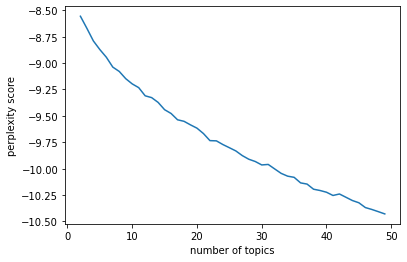

In [25]:
x = range(2,50)
plt.plot(x, perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

### 하이퍼 파라미터 선정 및 LDA 시각화

1. 학습된 코퍼스(말뭉치)로 토픽 개수를 선정하고 alpha, eta, iterations, cunk_size등 다양한 파라미터 적용 가능.

2. pyLDAvis를 불러온 뒤 학습된 모델 시각화 진행
파라미터의 조정에 있어서 크게 alpha,beta 값을 조정하게 되는데,
이에 따라 토픽 내 분포하는 문서, 단어의 분포가 달라짐.

3. 내가 원하는 주제들을 설명할 수 있는 단어들을 끌어 내기 위해
파라미터 값을 설정하기도 하므로 해당 단어들의 이해도나
문서에 담긴 도메인 이해도가 중요

* 추가로 해당 토픽에 묶인 단어들이 사용자 사전에 정의되지 않았다면
사용자 사전을 추가하여 단어를 등록하는 과정도 필요

In [26]:
# 위 결과 기반으로 토픽 개수 수정
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=50, alpha=0.1, id2word=dictionary)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [27]:
ldamodel.print_topics(num_words=20)

[(10,
  '0.022*"가수" + 0.019*"여성" + 0.017*"트롯" + 0.017*"공개" + 0.009*"보컬" + 0.008*"라이" + 0.008*"전국" + 0.008*"듀엣" + 0.008*"경연" + 0.007*"발라드" + 0.007*"어제" + 0.007*"프로그램" + 0.007*"라인업" + 0.006*"데뷔" + 0.006*"중인" + 0.006*"연주곡" + 0.006*"무대" + 0.006*"산책" + 0.006*"재질" + 0.006*"듀엣곡"'),
 (49,
  '0.049*"바람" + 0.042*"가을" + 0.030*"계절" + 0.021*"겨울" + 0.017*"내적" + 0.017*"유발" + 0.014*"댄스" + 0.014*"감성" + 0.013*"낙엽" + 0.013*"내적댄스" + 0.013*"랜덤" + 0.012*"누구" + 0.012*"작업" + 0.010*"마음" + 0.009*"질주" + 0.008*"준비" + 0.007*"제격" + 0.007*"감고" + 0.007*"나뭇잎" + 0.006*"만세"'),
 (29,
  '0.095*"기분" + 0.069*"전환" + 0.059*"기분전환" + 0.040*"드라이브" + 0.037*"감성" + 0.024*"날씨" + 0.018*"분위기" + 0.016*"필요" + 0.015*"트로트" + 0.013*"여름" + 0.012*"카페" + 0.011*"새벽" + 0.010*"커피" + 0.010*"도입부" + 0.010*"힐링" + 0.009*"느낌" + 0.009*"클럽" + 0.008*"선곡" + 0.008*"한잔" + 0.008*"하우스"'),
 (25,
  '0.024*"사람" + 0.023*"시기" + 0.020*"가요" + 0.020*"감미" + 0.017*"보컬" + 0.014*"감성" + 0.013*"매력적" + 0.011*"트랙" + 0.010*"날씨" + 0.009*"듀엣" + 0.009*"행복" + 0.009*"노랫말" + 0.009*

In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
31    -0.133751 -0.079026       1        1  3.418653
27    -0.122480 -0.090830       2        1  2.921707
14    -0.087023 -0.104654       3        1  2.603353
35    -0.027783 -0.117526       4        1  2.556443
29     0.215308 -0.149685       5        1  2.497723
10    -0.061103  0.002851       6        1  2.399337
37    -0.010767 -0.072002       7        1  2.300000
42    -0.036777 -0.082536       8        1  2.223375
15    -0.082123 -0.009542       9        1  2.221382
45     0.100238  0.052992      10        1  2.195753
21    -0.006101 -0.081281      11        1  2.151654
30     0.070127  0.042572      12        1  2.151307
3      0.081911  0.036807      13        1  2.146013
22     0.007802  0.078239      14        1  2.132393
9     -0.080778  0.005754      15        1  2.130391
44    -0.076425  0.028720      16        1  2.105393
43     0.024831  0.107750      17        1  2.088627
4     -0.056062 -0.069790      18        1  2.065584
12     0.027441  0.008510      19        1  2.060794
1      0.078797 -0.030065      20        1  2.046406
20     0.046823  0.031171      21        1  2.040592
49     0.034392  0.044122      22        1  2.030880
40    -0.106665 -0.029342      23        1  2.029952
48     0.161916 -0.049976      24        1  2.018500
33     0.073468 -0.073897      25        1  2.009833
18    -0.052592  0.037811      26        1  1.968269
28     0.038938  0.058910      27        1  1.947651
0      0.070635 -0.142837      28        1  1.930794
36    -0.003627  0.026124      29        1  1.910857
46     0.070515  0.019283      30        1  1.896418
41     0.054563  0.030998      31        1  1.867542
38     0.043605  0.058902      32        1  1.862019
13     0.028206 -0.017868      33        1  1.854806
11    -0.035035  0.075264      34        1  1.849333
34    -0.062703  0.001359      35        1  1.846654
6      0.016685  0.025065      36        1  1.822796
47     0.000149 -0.038208      37        1  1.762486
7     -0.018307  0.033399      38        1  1.726692
26     0.014794  0.033040      39        1  1.726466
19     0.081408  0.071647      40        1  1.725436
25    -0.021751 -0.019689      41        1  1.715723
2     -0.051944  0.033272      42        1  1.713298
32    -0.000572  0.057586      43        1  1.697019
17    -0.049554  0.078909      44        1  1.611208
39     0.001409  0.008853      45        1  1.606993
23    -0.024707  0.025679      46        1  1.595116
16     0.007409  0.070922      47        1  1.570499
5     -0.009498 -0.026031      48        1  1.530628
24    -0.061956  0.043421      49        1  1.478616
8     -0.071286  0.054853      50        1  1.236635, topic_info=     Term        Freq       Total Category  logprob  loglift
1733   가을  268.000000  268.000000  Default  30.0000  30.0000
275    팝송  184.000000  184.000000  Default  29.0000  29.0000
144    기분  271.000000  271.000000  Default  28.0000  28.0000
77     감성  352.000000  352.000000  Default  27.0000  27.0000
35     힙합  159.000000  159.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
1070   가족    2.259141   15.511851  Topic50  -5.4312   2.4662
418    명곡    2.951414  131.163811  Topic50  -5.1639   0.5986
13     시대    2.395964   37.156360  Topic50  -5.3724   1.6514
294    바다    2.078350   13.152922  Topic50  -5.5146   2.5477
144    기분    2.275191  271.327780  Topic50  -5.4241  -0.3885

[2705 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1810      3  0.786069   00
269       5  0.056197   10
269      16  0.028098   10
269      19  0.028098   10
269      24  0.028098   10
...     ...       ...  ...
35       39  0.056468   힙합
35       41  0.012549   힙합
35       45  0.012549   힙합
35       46  0.006274   힙합
35       48  0.100388   힙합

[6124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'yla

### 토픽에 할당된 키워드 추출(Topic-Keyword)

01. 각 토픽에 할당된 단어와 단어별 토픽 차지 비율 추출
02. 데이터 프레임화
03. 토픽별 추출

In [29]:
kk = ldamodel.show_topic(7, topn=80000)
type(ldamodel.show_topic)
kk2 = pd.DataFrame(kk)
kk2.to_csv("/content/drive/Othercomputers/내 노트북/Project/Models/Text/playlists_top_topics.csv", encoding="euc-kr")

#### 토픽에 할당된 문서 추출(Topic-Document)

- 각 문서별로 토픽에 할당되는 토픽 번호와 차지하는 비중을 만들기 위한 코드
- 해당 코드를 통해 문서 개별로 가장 크게 할당된 토픽의 번호와 비율 확인 가능,
여러 토픽에 중첩 할당 된 경우, 개별 할당된 값도 확인 가능

##### [분석 과정에서의 Idea]

단어별로 토픽 모델링 결과를 잘 나타내고서, 문서별로 다시 묶은 다음
각 주제에 해당하는 문서들끼리만 다시 토픽모델링 결과를 낸다면
하나의 주제에서 또 다르게 얘기하는 주제들을 끄집어 낼 수 있음

In [30]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다. 
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key = lambda x: (x[1]), reverse=True)

        # 각 문서에 대해서 비중이 높은 토픽 순으로 토픽을 정렬
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%)
        # EX) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): # 몇 번 토픽인지와 비중을 나눠서 저장
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_list]), ignore_index=True)
                # 가중 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장
            
            else:
                break
    return(topic_table)

In [31]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호를 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']
topictable[:]

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,36.0,0.3657,"[(28, 0.08137239), (32, 0.12718809), (35, 0.07..."
1,1,9.0,0.7103,"[(3, 0.03702333), (9, 0.7103108)]"
2,2,5.0,0.5463,"[(5, 0.54632056), (13, 0.10116222), (16, 0.045..."
3,3,36.0,0.7372,"[(36, 0.73716307), (45, 0.05411566)]"
4,4,34.0,0.2625,"[(0, 0.012500015), (1, 0.012501037), (2, 0.012..."
...,...,...,...,...
5510,5510,47.0,0.1862,"[(0, 0.014290136), (1, 0.014285714), (2, 0.014..."
5511,5511,0.0,0.1572,"[(0, 0.15715723), (1, 0.014286167), (2, 0.1571..."
5512,5512,31.0,0.4161,"[(0, 0.010000165), (1, 0.010000001), (2, 0.010..."
5513,5513,18.0,0.1811,"[(0, 0.0142857265), (1, 0.014286143), (2, 0.13..."


In [32]:
df

,pl_id,pl_name,pl_intro,pl_like,inserted_cnt,result
0,10656,듣는순간 흥폭발 신나고 중독성 있는 K-POP,케이팝이 끌리는날! 100곡의 신나고 중독성있는 케이팝 들어봐요,4,0,듣는순간 흥폭발 신나고 중독성 있는 K-POP 케이팝이 끌리는날! 100곡의 신나고...
1,10631,임창정이 추천하는 시대와 장르를 초월하는 음악,저는 시대와 장르를 초월하는 다양한 종류의 음악을 좋아합니다.저에게 음악적으로 영향...,279,1,임창정이 추천하는 시대와 장르를 초월하는 음악 저는 시대와 장르를 초월하는 다양한 ...
2,10629,[일상의 BGM] 감각적인 비트와 멜로디,2019.11.2비트감 있고 세련된 멜로디의 재즈힙합 곡 위주로 모아봤어요.루즈하지...,665,1,[일상의 BGM] 감각적인 비트와 멜로디 2019.11.2비트감 있고 세련된 멜로...
3,10627,크리에이티브 영감을 자극하는 선율의 연주곡,"집중이 필요할 때, 창의적인 작업 중일 때, 업무 효율을 늘리고 싶을 때 들어보세요...",153,1,"크리에이티브 영감을 자극하는 선율의 연주곡 집중이 필요할 때, 창의적인 작업 중일 ..."
4,10626,작업할 때 듣기 좋은 잔잔한 POP,당신의 작업을 응원합니다.,12,1,작업할 때 듣기 좋은 잔잔한 POP 당신의 작업을 응원합니다.
...,...,...,...,...,...,...
5510,5,주말의 여유를 느끼고 싶을때 들으면 좋은 곡들,,11,0,주말의 여유를 느끼고 싶을때 들으면 좋은 곡들
5511,4,늦은 밤에 혼자 듣기 좋은 발라드 노래,늦은 밤 혼자 듣기 좋은 발라드 노래,6454,0,늦은 밤에 혼자 듣기 좋은 발라드 노래 늦은 밤 혼자 듣기 좋은 발라드 노래
5512,3,싸이월드 bgm 인기곡차트를 휩쓴 추억의 노래들 (,,2969,2,싸이월드 bgm 인기곡차트를 휩쓴 추억의 노래들 (
5513,2,펑펑 울고 싶은 날 들어요. 이별을 노래한 잔잔한 발라드,,2322,0,펑펑 울고 싶은 날 들어요. 이별을 노래한 잔잔한 발라드


In [33]:
result = pd.concat([topictable,df], axis=1, join='outer')
result

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중,pl_id,pl_name,pl_intro,pl_like,inserted_cnt,result
0,0,36.0,0.3657,"[(28, 0.08137239), (32, 0.12718809), (35, 0.07...",10656,듣는순간 흥폭발 신나고 중독성 있는 K-POP,케이팝이 끌리는날! 100곡의 신나고 중독성있는 케이팝 들어봐요,4,0,듣는순간 흥폭발 신나고 중독성 있는 K-POP 케이팝이 끌리는날! 100곡의 신나고...
1,1,9.0,0.7103,"[(3, 0.03702333), (9, 0.7103108)]",10631,임창정이 추천하는 시대와 장르를 초월하는 음악,저는 시대와 장르를 초월하는 다양한 종류의 음악을 좋아합니다.저에게 음악적으로 영향...,279,1,임창정이 추천하는 시대와 장르를 초월하는 음악 저는 시대와 장르를 초월하는 다양한 ...
2,2,5.0,0.5463,"[(5, 0.54632056), (13, 0.10116222), (16, 0.045...",10629,[일상의 BGM] 감각적인 비트와 멜로디,2019.11.2비트감 있고 세련된 멜로디의 재즈힙합 곡 위주로 모아봤어요.루즈하지...,665,1,[일상의 BGM] 감각적인 비트와 멜로디 2019.11.2비트감 있고 세련된 멜로...
3,3,36.0,0.7372,"[(36, 0.73716307), (45, 0.05411566)]",10627,크리에이티브 영감을 자극하는 선율의 연주곡,"집중이 필요할 때, 창의적인 작업 중일 때, 업무 효율을 늘리고 싶을 때 들어보세요...",153,1,"크리에이티브 영감을 자극하는 선율의 연주곡 집중이 필요할 때, 창의적인 작업 중일 ..."
4,4,34.0,0.2625,"[(0, 0.012500015), (1, 0.012501037), (2, 0.012...",10626,작업할 때 듣기 좋은 잔잔한 POP,당신의 작업을 응원합니다.,12,1,작업할 때 듣기 좋은 잔잔한 POP 당신의 작업을 응원합니다.
...,...,...,...,...,...,...,...,...,...,...
5510,5510,47.0,0.1862,"[(0, 0.014290136), (1, 0.014285714), (2, 0.014...",5,주말의 여유를 느끼고 싶을때 들으면 좋은 곡들,,11,0,주말의 여유를 느끼고 싶을때 들으면 좋은 곡들
5511,5511,0.0,0.1572,"[(0, 0.15715723), (1, 0.014286167), (2, 0.1571...",4,늦은 밤에 혼자 듣기 좋은 발라드 노래,늦은 밤 혼자 듣기 좋은 발라드 노래,6454,0,늦은 밤에 혼자 듣기 좋은 발라드 노래 늦은 밤 혼자 듣기 좋은 발라드 노래
5512,5512,31.0,0.4161,"[(0, 0.010000165), (1, 0.010000001), (2, 0.010...",3,싸이월드 bgm 인기곡차트를 휩쓴 추억의 노래들 (,,2969,2,싸이월드 bgm 인기곡차트를 휩쓴 추억의 노래들 (
5513,5513,18.0,0.1811,"[(0, 0.0142857265), (1, 0.014286143), (2, 0.13...",2,펑펑 울고 싶은 날 들어요. 이별을 노래한 잔잔한 발라드,,2322,0,펑펑 울고 싶은 날 들어요. 이별을 노래한 잔잔한 발라드


In [37]:
df_results = result[['pl_id', '가장 비중이 높은 토픽']]
df_results

,pl_id,가장 비중이 높은 토픽
0,10656,36.0
1,10631,9.0
2,10629,5.0
3,10627,36.0
4,10626,34.0
...,...,...
5510,5,47.0
5511,4,0.0
5512,3,31.0
5513,2,18.0


In [ ]:
result.to_csv("/content/drive/Othercomputers/내 노트북/Project/Models/Text/top_doc.csv", encoding="utf-8")